## Python 3 Version of Andromeda

In [1]:
%matplotlib notebook   
#this is to get render in notebook
import numpy as np
import pandas as pd
#import math
import random
#import os
#import re
import cv2
from skimage.transform import resize
#import csv
#from functools import partial
#from tqdm import tqdm
import traceback

#from os import listdir
#from os.path import isfile, join
#from math import isnan

""" 
unnecessary with import from dimension_reduction
#import required sklearn packages:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise   #probably better: from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
#and fix below 
"""
from andromeda.dimension_reduction import distance_matrix_2D, distance_matrix_HD, dimension_reduction, stress #, compute_mds
from sklearn.metrics import silhouette_score # never used

#import matplotlib packages
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#from matplotlib.patches import FancyBboxPatch
#from matplotlib.widgets import Slider, Button

#import ipyplot
import io
import urllib.request

#import display packages
from IPython.display import HTML, Javascript, display

#import ipywidges and packages
import ipywidgets as widgets
from ipywidgets import interact, Layout, ButtonStyle #Button, GridBox,
    # interact vs interactive: with interactive the checkboxes don't appear, otherwise seems the same

#import interaction (Drag functions)
from andromeda.DraggablePointsClass import DraggablePoints

### Instantiate Upload Button

In [2]:
w = widgets.IntSlider()
uploader = widgets.FileUpload(accept = '*.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
                              multiple = False,  # True to accept multiple files upload else False
                              description = 'Upload file',
                              style=ButtonStyle(button_color='lightblue')
)
#only allow single file upload

display(uploader)



HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

FileUpload(value={}, accept='*.csv', description='Upload file', style=ButtonStyle(button_color='lightblue'))

### Run everything on launch button

Does generate button before ready 

In [11]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    #display(Javascript("Jupyter.notebook.execute_cell(2)"))

button = widgets.Button(description = "Launch Andromeda", 
                        style = ButtonStyle(button_color='lightblue'))
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description='Launch Andromeda', style=ButtonStyle(button_color='lightblue'))

#### try-exception

I think this try, exception pair is born out of the fact that the whole notebook gets run before it has everything it needs, so there's a pass to then be able to run it again. However, the exception buried errors.

In [12]:
try:    
    input_file = list(uploader.value.values())[0]
    content = input_file['content']
    content = io.StringIO(content.decode('utf-8'))
    df = pd.read_csv(content)
    #df.rename(columns = {'Image_Label':'Name'}, inplace=True)
    df.set_index('Image_Label', inplace = True)

    label_names = df.index.tolist()
    image_paths = {}
    for name in label_names:
        image_paths[name] = df['Image_Link'][name]

    df = df.loc[:, ~df.columns.isin(['Image_Link','Species','User','Date','Time','Annotations','Hex_Color_Code'])]
    df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()] 
    df_category = df.select_dtypes(exclude='number') #'object'  #never used
    normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
    min_weight, max_weight = 0.00001, 0.9999
    init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
    weights = pd.Series(init_weight, 
                        index = normalized_df.columns, 
                        name = "Weight")  # the current weight list
    df_2D = dimension_reduction(normalized_df, weights)   # the current projected data

except Exception as ex:
    #pass
    traceback.print_exception(ex)



/opt/homebrew/Caskroom/miniforge/base/envs/andromeda/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


#### This will update the plot?

In [13]:
##Updating Weights, based on manual re-organization of images in the plot


def new_proposal(current, step, direction):
    '''
    what is this?
    seems to be a suggestion of new weights
    '''
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

def inverse_DR(dataHD, data2D, curWeights = None): 
    '''

    Generates new weights based on manual movements of the images in the plot.

    Parameters:
    -----------
    dataHD - DataFrame or Array of high-dimensional data
    data2D - DataFrame or Array of projected 2D data
    curWeights - Weights for features (columns of dataHD). list? Default value is None. 

    Returns:
    --------
    Series of new weights

    '''
    """
    ......
    @parameters:
        dataHD[pd.df or np.array]: high-dimensional data
        data2D[pd.df or np.array]: projected 2D data
    @return[pd.Series]: new weights  
    """
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency  <--??
    row, col = dataHD.shape
    
    if curWeights == None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency <---re-use? 
        #defining this way to confirm size/shape is the same for true_divide output later
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency                                
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')   # printing to console

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            '''
            curWeights is being used instead of newWeights because
            they are equal to each other until this next step in the first iteration, but then not
            do need to instantiate newWeights to proper size/shape first for this to work
            '''
            np.true_divide(curWeights, s, out = newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw/s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out = dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')  # printing to console, get warning on `normalized_stress`
    return pd.Series(curWeights, index=col_names, name="Weight")

### Create the widgets/displays

In [14]:
## displays, 
imgDisplaySize = 0.30
        

def create_plot(data2D, title = False): 
    '''
    Function to generate the button to activate the size slider chosen size.
    
    Parameters:
    -----------
    data2D - DataFrame or Array of projected 2D data
    imgDisplaySize - [float]: zoom image displayed size
    title - Boolean: toggle title. Default is False.

    Returns:
    --------
    ax - Axes for plot
    
    '''
    """
    @parameters:
        data2D[pd.df or np.array]: projected 2D data
        title[boolean]: toggle title or not 
    @return[AxesSubplot]: plotting axes
    """
    # Initialize DR plot figure   
    fig, ax = plt.subplots(figsize= (6,6), dpi=80)
    ax.selected_text = ax.figure.text(0, 
                                      0.005, 
                                      'Selected: none', 
                                      wrap = True, 
                                      color = 'green')
    #no ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
#     global imageIndex_path_dict
    
    # Store state data:
    ax.dragpoint = None
    draw_plot(ax, data2D, title = title)
        
    return ax


def url_to_image(url):
    '''
    download the image, convert it to a NumPy array, and then read
    it into OpenCV format

    Parameters:
    -----------
    url - url of plot?

    Returns:
    --------
    immage - Image of the plot? OpenCV format
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image


def image_preprocessing(imgIndex):
    """
    segment images if background is black
    @parameters:
        imgIndex[str]: image index
    @return[np.array(image)]: processed image
    """

    #global image_paths   #variable defined (and initiated as empty) in try statement.
                         #defining it as global here would change the value, 
                         #but the value isn't being changed, it's being used
                         #commenting out doesn't fix, but doesn't seem to break
    path = image_paths[imgIndex]
    up_width = 150
    up_height = 150
    up_points = (up_width, up_height)    
    src = url_to_image(path)
    src = cv2.resize(src, 
                     up_points, 
                     interpolation = cv2.INTER_LINEAR)
    tmp = cv2.cvtColor(src, 
                       cv2.COLOR_BGR2GRAY)        
    _,alpha = cv2.threshold(tmp, 
                            0, 
                            255, 
                            cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [r,g,b, alpha]
    processed_img = cv2.merge(rgba, 4)

    return processed_img

def draw_plot(ax, data2D, imgSize = imgDisplaySize, title = False, image = True): 
    """

    Function drawing the plot? Also calls the interactive "DraggablePoints" Class to allow interaction with plot.
    Creates green circles behind images on click?

    @parameters:
        ax[AxesSubplot]: plot ax
        data2D[dataframe]: projected 2D dataframe
        imgSize[float]: zoom parameter of OffsetImage, determine size of displaying images. Default imgDisplaySize = .3.
        title[boolean]: whether toggle title or not. Default is False
        image[boolean]: whether toggle image or not. Default is True
    """
    
    labels_df = data2D.index.to_series().apply(lambda x: x.split('/')[0])
    data2D['label'] = labels_df
    label_list = list(set(data2D['label']))
    conversion_dict = {k:v for k,v in zip(label_list,range(len(label_list)))}
    data2D['label_num'] = data2D['label'].replace(conversion_dict)
    ax.clear()
    wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min()) # max range of x,y axes
    if not image:
        print("not image")
        cnorm = Normalize(vmin = data2D.label_num.min(),                #just import from matplotlib.colors
                            vmax = data2D.label_num.max())
        
        ax.circles = data2D.apply(axis=1, func=lambda row: 
                                    mpatches.Circle(xy = (row.x, row.y), 
                                                        radius = wid/70, 
                                                        alpha=0.95, 
                                                        label=row.label_num,
                                                        color = plt.cm.Set3(cnorm(row.label_num)), 
                                                        picker = True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')
    else:
        print("image true")
        ax.circles = []
        for x0, y0, index in zip(data2D.x, data2D.y, data2D.index):
            ax.circles.append(mpatches.Circle(xy = (x0, y0), 
                                                 radius = wid*imgSize/3, 
                                                 alpha = 0.5, 
                                                 color = 'none', 
                                                 picker = True))

        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            processed_img = image_preprocessing(c.label)
            img = OffsetImage(processed_img,zoom=imgSize)
            c.ab = AnnotationBbox(img, (c.center[0], c.center[1]), frameon=False)
            ax.add_artist(c.ab)
            if title:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], c.label, color='black')
            else:
                c.text = ax.text(c.center[0]+c.radius, c.center[1], "", color='none')

    # Make plot circles draggable
    ax.dragpoint = DraggablePoints(ax, ax.circles)
    # Clean up the plot 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    print(ax)
    print(ax.figure)
    ax.figure.canvas.draw()
    #ax.figure.show()
    #axis is reset, but plot not drawn
    #plot_ax = create_plot(data2D, imgSize)
    #return ax
    


In [15]:
# widget coding


def create_size_slider(imgDisplaySize):
    """
    Create image size adjust slider
    @parameters:
        imgDisplaySize[float]: zoom image displayed size
    @return[widgets slider]: return the size adjustment slider 
    """

    style = {'description_width': 'initial'}
    size_slider = widgets.FloatSlider(min = 0,                              
                                      max = 1, 
                                      step = 0.01, 
                                      value = imgDisplaySize, 
                                      description = 'Adjust image size', 
                                      style = style, 
                                      continuous_update = False, 
                                      readout_format = '.5f',)
    size_slider.style.handle_color = 'lightblue'
    return size_slider

# sliders for weights
def create_sliders(wts):
    '''
    Function to generate a slider for each feature's weight
    
    Parameters:
    -----------
    wts - Series consisting of the potential weights for each feature.

    Returns:
    --------
    sliders - Wigets (sliders).
    
    '''
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min = min_weight, 
                                   max = max_weight, 
                                   step = 0.01, 
                                   value = value, 
                                   description = label, 
                                   continuous_update = False, 
                                   layout = Layout(width = '80%', height = '20px'),     #widgets.Layout
                                   readout_format = '.5f')    
                for (label, value) in wts.items()]
    #for (label, value) in wts.items():
        #print(label, " , ", value)
#     for slider in sliders:
#         slider.style.handle_color = 'lightgreen'
#         display(slider)
        
    return sliders 

# checkboxes --These select a unselect, don't do toggle
def create_checkbox(size_slider, ax, df_2D):
    '''
    Function to generate the checkboxs for toggling the images and titles. Titles are the image index in the DataFrame.
    
    Parameters:
    -----------
    size_slider - slider for size of images (size_slider.value gives desired size)
    ax - Axes of plot
    df_2D - DataFrame of projected 2D data

    Returns:
    --------
    title_checkbox - Checkbox to toggle titles (default is off)
    image_checkbox - Checkbox to toggle images (default is on)
    
    '''
    """
    @return: create the checkbox to toggle the images and titles(image index in the dataframe)  
    """
    title_checkbox = widgets.Checkbox(False,                             
                                      description = 'Toggle Titles', 
                                      indent=False,   
                                      layout = Layout(width='20%', height='20px'))
    image_checkbox = widgets.Checkbox(True, 
                                      description = 'Toggle Images', 
                                      indent = False,
                                      layout = Layout(width='20%', height='20px'))
   # print("title checkbox is", title_checkbox.value)
   # print("image checkbox is", image_checkbox.value)

    #running after click, but not updating plot
    def title_check_clicked(x): 
        '''
        Defines interaction with title_checkbox
        If clicked, look at value of image_checkbox to determine if image is shown in plot.
        Then get answer of title_checkbox clicked for whether to show title or not.
        
        Parameters:
        -----------
        x - Checkbox being interacted with (title_checkbox)
        
        '''  
        image = image_checkbox.value
        print(image, ax.figure.canvas)
        draw_plot(ax, df_2D, size_slider.value, x, image)
        print(image, x, ax.figure.canvas, "plot drawn?")
        #ax.figure.canvas.draw_idle()
       # print(image, x, "ax.figure drawn?")
    interact(title_check_clicked, x = title_checkbox)                 #Q of interact vs interactive
    title_checkbox.observe(title_check_clicked)

    #running after click, but not updating plot
    def image_check_clicked(x):   
        '''
        Defines interaction with image_checkbox
        If clicked, look at value of title_checkbox to determine if title is shown in plot.
        Then get answer of image_checkbox clicked for whether to show image or not.
        
        Parameters:
        -----------
        x - Checkbox being interacted with (image_checkbox)
        
        '''  
        title = title_checkbox.value 
        print(title)  
        draw_plot(ax, df_2D, size_slider.value, title, x)
        print(title, x, ax.figure.canvas, "plot drawn?")
       # ax.figure.canvas.draw()
       # print(title, x, ax.figure.canvas, "ax.figure drawn?")

    interact(image_check_clicked, x = image_checkbox)
    image_checkbox.observe(image_check_clicked)
    return title_checkbox, image_checkbox


def create_size_slider_button(size_slider, ax, df_2D): 
    '''
    Function to generate the button to activate the size slider chosen size.
    
    Parameters:
    -----------
    size_slider -
    ax - Axes of plot
    df_2D - DataFrame of projected 2D data

    Returns:
    --------
    size_apply_button - Button (widget) to apply the size set by the slider.
    
    '''
    """
    @parameters:
        size_slider: 
        ax:
    @return[button]: return image size adjust button
    """
    size_apply_button = widgets.Button(description = 'Apply Slider Size',  
                                        style = ButtonStyle(button_color = 'lightblue'))
    
    
    def size_slider_button_clicked(change):         #change is used implicitly
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_title = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, 
                  df_2D, 
                  size_slider.value, 
                  toggle_title, 
                  toggle_image)
        ax.figure.canvas.draw()
        
    size_apply_button.on_click(size_slider_button_clicked)
    return size_apply_button

# apply slider weights
def create_slider_buttons(sliders, size_slider, ax, normalized_df):  
    '''
    Function to generate the buttons to activate the slider weight changes for all sliders.
    
    Parameters:
    -----------
    sliders - [list?] of sliders/features.
    size_slider -
    ax - Axes of plot
    normalized_df - Normalized DataFrame of image data?

    Returns:
    --------
    apply_button - Button (widget) to apply the weights set by the sliders to their respective features.
    
    '''  
    #no need to pass df_2D because redefined before use
    apply_button = widgets.Button(description = 'Apply Slider Weights', 
                                  style = ButtonStyle(button_color = 'lightgreen'), 
                                  layout = Layout(width='22.7%'))

    # Callback functions
    def apply_button_clicked():       #removed the input (change) that isn't used
        ''' 
        Use the slider values to recompute the DR and redraw the plot
        '''
        #global weights, df_2D #, imageIndex_path_dict   # Update weights and df_2D globals
                                #imageIndex_path_dict is never used
                                #passing df_2D where needed
        weights = pd.Series([s.value for s in sliders], 
                            index = normalized_df.columns, 
                            name='Weight')
        df_2D = dimension_reduction(normalized_df, weights)   
        
        # Redraw the plot
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_title = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax, 
                  df_2D, 
                  size_slider.value, 
                  toggle_title, 
                  toggle_image)
        ax.figure.canvas.draw()

    apply_button.on_click(apply_button_clicked)

    return apply_button


def create_reset_button(sliders, size_slider, ax, normalized_df):
    '''
    Function to generate the button to reset the plot.
    
    Parameters:
    -----------
    sliders - [list?] of sliders/features.
    size_slider -
    ax - Axes of plot
    normalized_df - Normalized DataFrame of image data?

    Returns:
    --------
    reset_button - Button (widget) to reset the plot to original.
    
    '''  
    """
    @return[button]: return reset plot button  
    """  
    #no need to pass df_2D since it's redefined before use
    reset_button = widgets.Button(description = 'Reset Plot', 
                                  style = ButtonStyle(button_color = 'salmon'))
    
    def reset_button_clicked():             #removed the input (change) that isn't used
        for s in sliders:
            s.value = init_weight            
        #global weights, df_2D, normalized_df   # Update weights and df_2D globals -- remove global
        weights = pd.Series(init_weight, 
                            index = normalized_df.columns, 
                            name = "Weight")
        df_2D = dimension_reduction(normalized_df, weights)   
        toggle_image = hasattr(ax.dragpoint.artists[0], 'ab')
        toggle_title = ax.dragpoint.artists[0].text.get_text() != ''

        # Redraw the plot
        draw_plot(ax, 
                  df_2D, 
                  size_slider.value, 
                  toggle_title, 
                  toggle_image)
        ax.figure.canvas.draw()

    reset_button.on_click(reset_button_clicked)

    return reset_button

def create_inverse_button(sliders, ax, normalized_df):
    #removed size_slider and fig_show = False, as they are not used
    '''
    Generates button to call function to rebalance the weights based on the moved images when the inverse button is clicked

    Parameters:
    -----------
    sliders - [list?] of sliders/features.
    ax - Axes of plot
    normalized_df - Normalized DataFrame of image data?

    Returns:
    --------
    inverse_button - Button (widget) to recalculate weights based on the reorganized images in plot.
        
    '''
    """
    @return[button]: return 'Learn New Weights' and 'Update Projections' buttons
    """
#why passing unused variables?

    inverse_button = widgets.Button(description = 'Apply Moved Observations',
                                        style = ButtonStyle(button_color = 'darkseagreen'), 
                                        layout = Layout(width='22.7%'))
#     copy_button = widgets.Button(description='Update Projections',
#                                  style=ButtonStyle(button_color='darkseagreen'))

    def inverse_button_clicked(): #removed the input (change) that isn't used
        '''
        Calls inverse_DR to rebalance the weights based on the moved images when the inverse button is clicked.
        Only does so if at least 2 points moved
        Sets new weights of sliders at end
        
        '''

        # Check number of points moved
        n = sum([i.selected for i in ax.dragpoint.artists])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        data2Dnew = pd.DataFrame([c.center for c in ax.dragpoint.artists if c.selected], 
                                    columns = ['x','y'], 
                                    index = [c.label for c in ax.dragpoint.artists if c.selected]) 
        #global normalized_df
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        #global weights
        weights = inverse_DR(dataHDpart, data2Dnew)
        
        #set sliders' new weights
        for i,s in enumerate(sliders):
            s.value = weights[i]

    inverse_button.on_click(inverse_button_clicked)
        
    return inverse_button

## Make Plot

<IPython.core.display.Javascript object>


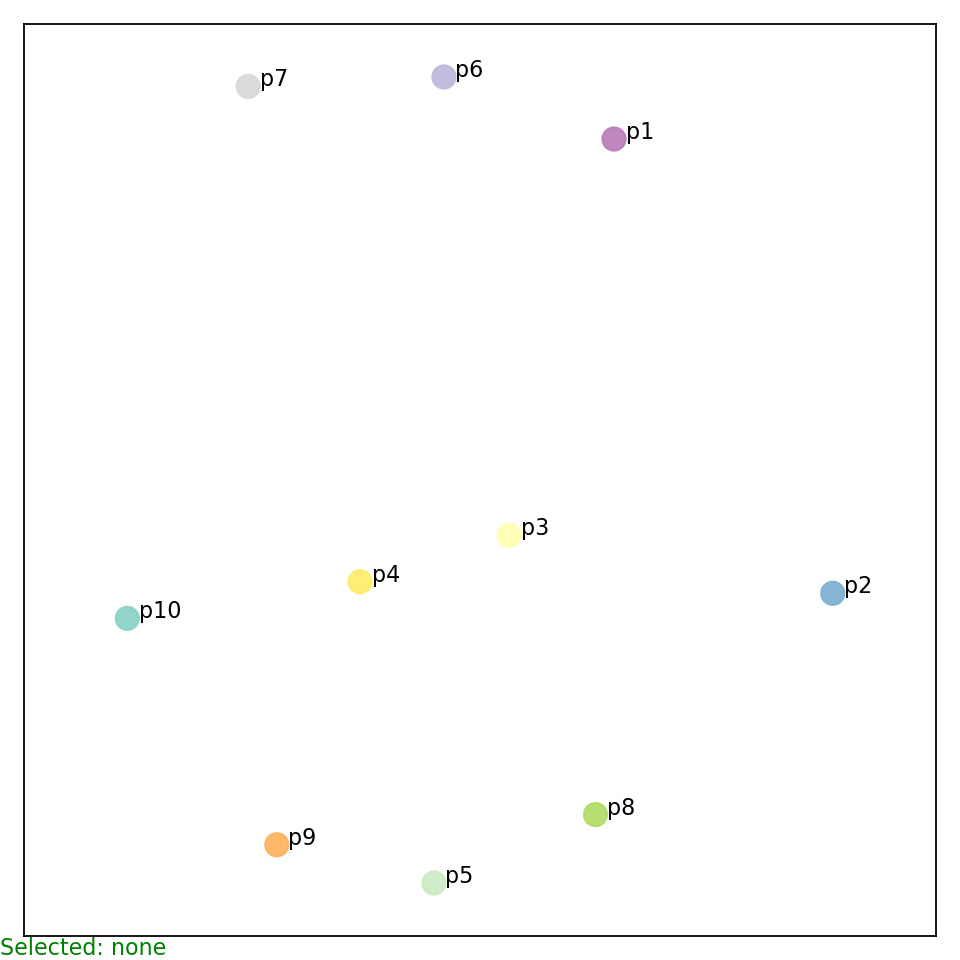

image true
Axes(0.025,0.025;0.95x0.95)
Figure(480x480)


In [16]:
if 'df_2D' in locals():
    plot_ax = create_plot(df_2D) #, imgDisplaySize)

## Display the widgets to adjust the plot

Will likely need to connect this to the plot display to put them on the side.

In [17]:
if 'df_2D' in locals():
    size_slider = create_size_slider(imgDisplaySize)
    sliders = create_sliders(weights)
    size_apply_button = create_size_slider_button(size_slider, plot_ax, df_2D)

    inverse_button = create_inverse_button(sliders, plot_ax, normalized_df)
    display(widgets.HBox([inverse_button, create_slider_buttons(sliders, size_slider, plot_ax, normalized_df),
                          create_reset_button(sliders, size_slider, plot_ax, normalized_df)]))
    display(widgets.HBox([size_slider, size_apply_button]))

    point_attribute = create_checkbox(size_slider, plot_ax, df_2D)

    for slider in sliders:
        slider.style.handle_color = 'lightgreen'
        display(slider)

interactive(children=(Checkbox(value=False, description='Toggle Titles', indent=False, layout=Layout(height='2…

interactive(children=(Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20…

FloatSlider(value=1e-05, continuous_update=False, description='Long', layout=Layout(height='20px', width='80%'…

FloatSlider(value=1e-05, continuous_update=False, description='R1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B1', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='R2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B2', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='R3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='G3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='B3', layout=Layout(height='20px', width='80%'),…

FloatSlider(value=1e-05, continuous_update=False, description='Contour_Area', layout=Layout(height='20px', wid…

FloatSlider(value=1e-05, continuous_update=False, description='Aspect_Ratio', layout=Layout(height='20px', wid…

FloatSlider(value=1e-05, continuous_update=False, description='Extent', layout=Layout(height='20px', width='80…

FloatSlider(value=1e-05, continuous_update=False, description='Solidity', layout=Layout(height='20px', width='…

TypeError: create_slider_buttons.<locals>.apply_button_clicked() takes 0 positional arguments but 1 was given

False
image true
Axes(0.025,0.025;0.95x0.95)
Figure(960x960)
False {'name': '_property_lock', 'old': traitlets.Undefined, 'new': {'value': False}, 'owner': Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20px', width='20%')), 'type': 'change'} <matplotlib.backends.backend_nbagg.FigureCanvasNbAgg object at 0x1611c5190> plot drawn?
False
image true
Axes(0.025,0.025;0.95x0.95)
Figure(960x960)
False {'name': 'value', 'old': True, 'new': False, 'owner': Checkbox(value=False, description='Toggle Images', indent=False, layout=Layout(height='20px', width='20%')), 'type': 'change'} <matplotlib.backends.backend_nbagg.FigureCanvasNbAgg object at 0x1611c5190> plot drawn?
False
image true
Axes(0.025,0.025;0.95x0.95)
Figure(960x960)
False {'name': '_property_lock', 'old': {'value': False}, 'new': {}, 'owner': Checkbox(value=False, description='Toggle Images', indent=False, layout=Layout(height='20px', width='20%')), 'type': 'change'} <matplotlib.backends.backend

In [18]:
draw_plot(plot_ax, df_2D)

image true
Axes(0.025,0.025;0.95x0.95)
Figure(480x480)
